# 1 分枝定界算法，基本思想
* 在解空间中搜索，生成状态空间树；
* 采用**宽度优先搜索**，用**表**记录活节点
* 在扩展节点处：
    * 首先生成其所有的儿子节点,
        * 将那些导致不可行解或导致非最优解的儿子节点舍弃，
        * 其余儿子节点加入活节点表中。
    * 然后，从活节点表中取出一个节点作为当前扩展节点，
    * 重复上述节点扩展过程。
* 队列式分枝限界算法：
    * 将活节点组织成先进先出（FIFO）或后进先出(LIFO)队列，
    * 不满足约束条件的节点不放入队列。
* 优先队列式分枝限界算法：
    * 将活节点组织成最大堆（或最小堆），
    * 优先级高的首先取作当前扩展节点。
    * 节点的优先级：
        * 常常根据**目标函数**确定，
            * 最大化问题：常引用一个可能获得的**最大目标值**的一个上界；
            * 最小化问题：则使用可能获得**最小目标值**的一个下界。
            * 这两个界都是动态确定的。
* 目的：达到**最小成本搜索**是确定节点优先级的根本目的。


# 2.TSP
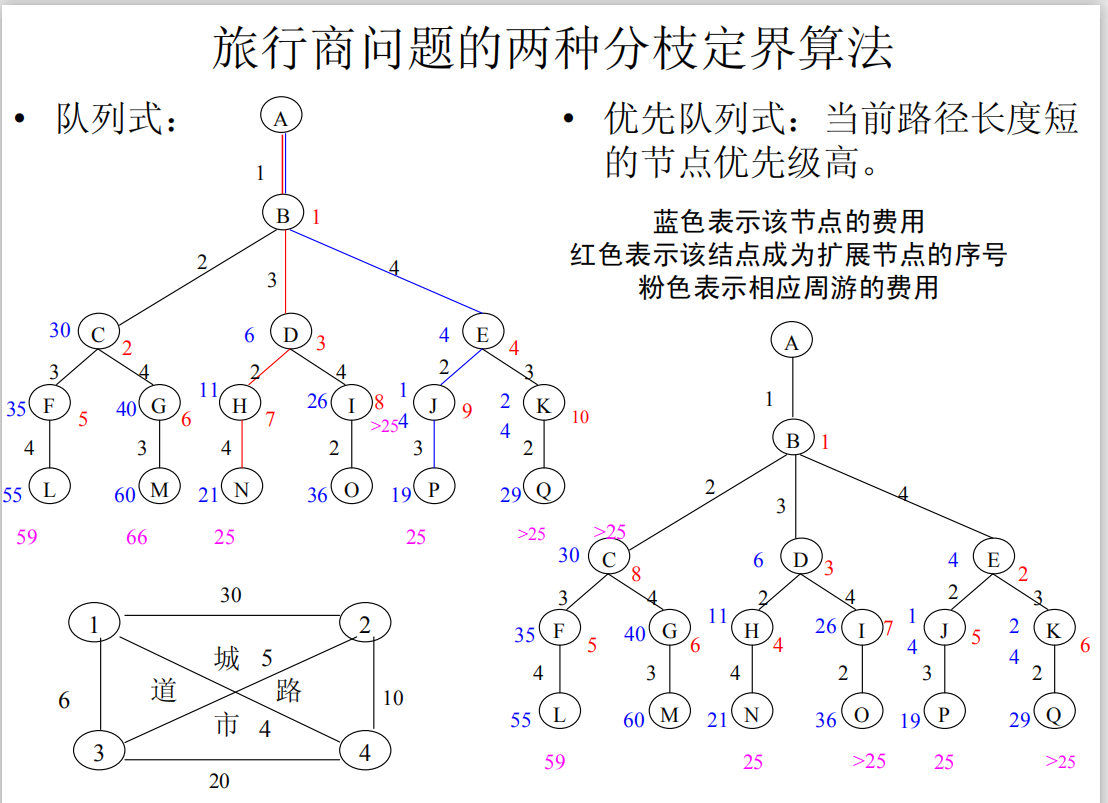

# 2.0/1背包问题
* 用**优先队列式**分枝定界法解0/1背包问题需要确定：
    1. 解空间树中**节点的结构**；
    2. 如何生成一个给定节点的**儿子**节点；
    3. 如何**组织活节点表**；
    4. 如何**识别答案**节点。
* 每个节点X有六个信息段：
    * Parent：节点X的父亲节点连接指针；
    * Level：标志出节点X在解空间树中的深度；
    * Tag ：用来标记输出最优解的各个分量xi ；
    * CC ：记录背包在节点X处(状态下)背包的剩余空间；
    * CV ：记录背包在节点X处(状态下)背包内物品的价值；
    * CUB：背包在节点X处可能达到的物品价值上界估值 Puv。
    * 目标值动态预测prev：到目前为止所知道的最佳目标值--初始状态为第一个点的pvl
    * puv/pvu:上界Pvu=Pvl+rw*P[i]/W[i]#（放不进去了，但按比例塞一下的话还可以），第一个塞不进去的：i
    * pvl:按贪心得到的最大的价值，若第i个塞不进去，跳过了继续塞
* 活节点表的组织：采用优先队列
    * 优先级：puv的最大堆，信息段CUB中的值做为确定该节点优先级的依据；
* 剪枝条件：如果Puv(X)≤prev，则杀死节点X，即X不放入节点表。
* 六个辅助子程序
    * LUBound：计算当前被搜索节点的Pvl和Pvu值；
    * NewNode：生成新节点，给各个信息段置入适当的值，并将此节点加入节点表；
    * GetNode：取一个可用节点；
    * Init：对可用节点表和活节点表置初值；
    * Largest：在活节点表中取一个具有最大Pvu值节点作为当前扩展节点；
    * Finish：打印出最优解的值和此最优解中的物品标号。

In [2]:
class Node(object):
    def __init__(self,par,lev,t,cap,cv,ub):
        self.parent=par;
        self.level=lev;#当前节点的级
        self.tag=t#左1，右0
        self.CC=cap#当前剩余容量
        self.CV=cv#当前价值
        self.CUB=ub#可能达到的物品价值上界估计
        
        
    def print(self):
        return "Node:(level=%d,tag=%d,CC=%d,CV=%d,CUB=%d)"%(self.level,self.tag,self.CC,self.CV,self.CUB)
        
def Finish(ANS,N):
    
    s=""
    for j in range(N,0,-1):
        if(ANS.tag==1):
            s=s+str(j)+" "
        ANS=ANS.parent

    print("result:"+s)

        
def LUBound(P,W,cap,cv,N,k,Pv1,Pvu):#求最大收益的上下界
#     k为当前节点的级level-1
# cap背包当前剩余容量，
# cv背包当前价值总量
# 还有level->N要考虑
    rw=cap#随时记录剩余总量
    Pvl=cv
    for i in range(k,N):
        if(rw<W[i]):#至少有一件商品无法放入的情况下
            Pvu=Pvl+rw*P[i]/W[i]#（放不进去了，但按比例塞一下的话还可以）
            for j in range(i+1,N):#跳过第i个继续塞
                if(rw>=W[j]):
                    rw=rw-W[j]
                    Pvl=Pvl+P[j]
#             print(i,rw,Pvl,Pvu)
            return Pvl,Pvu
        #都能放进去的情况下
        rw=rw-W[i]
        Pvl=Pvl+P[i]
#         print(i,rw,Pvl)
    Pvu=Pvl
    return Pvl,Pvu
        
    
def LOCKNAP(P,W,M,N):#物品序号
#     #满足：P[i]/W[i]>=P[i+1]/W[i+1]
#     M背包容量，Pvl价值估计下界,Pvu上界（放不进去了，但按比例塞一下的话还可以）,cap,cv包内价值,prev到目前所知道的最佳目标值
# P价值，W重量
# ANS，X,N物品数目
# 初始化init
#     GetNode(E);#生成根节点
    Live=[]#活节点表
    Tree=[]
    root=Node(-1,0,1,M,0,0)    
    Pv1=0
    Pvu=0
    Pvl,Pvu=LUBound(P,W,root.CC,root.CV,N,root.level,Pv1,Pvu)
    prev=Pvl
    root.CUB=Pvu
    root.tag=0
    Tree.append(root)
    print("root",root.print())
    E=root
    ANS=root
    while(True):
        i=E.level+1
        cap=E.CC
        cv=E.CV
#         print(i)
        if(i>N):
            if(cv>prev):
                prev=cv
                ANS=E
        else:#E是内部节点
            if(cap>=W[i-1]):#左儿子可行
                left=Node(E,i,1,cap-W[i-1],cv+P[i-1],E.CUB)
                print("left:",left.print())
                Live.append(left)
                Tree.append(left)
#             print(left.print())
            Pvl,Pvu=LUBound(P,W,cap,cv,N,i,Pv1,Pvu)
            print(Pvl,Pvu)
            if(Pvu>=prev):#右儿子会活
                right=Node(E,i,0,cap,cv,Pvu)
                print("right:",right.print())
                Live.append(right)
                Tree.append(right)
                prev=max(prev,Pvl-0.1)
        z=0
        while(len(Live)>0):
#             print(z,len(Live))
            if(Live[z].CUB<prev):
                Live.remove(Live[z])
                z-=1
            z+=1
            if(z==len(Live)):
                break
        if(len(Live)==0):
            break
        
        E=max(Live,key=lambda x:x.CUB)        
        Live.remove(E) 
        print("E:",E.print())
        if(E.CUB<=prev):
            break
    Finish(ANS,N)

P=[10,10,12,18]
W=[2,4,6,9]
M=15
N=4
LOCKNAP(P,W,M,N)

root Node:(level=0,tag=0,CC=15,CV=0,CUB=38)
left: Node:(level=1,tag=1,CC=13,CV=10,CUB=38)
22 32.0
right: Node:(level=1,tag=0,CC=15,CV=0,CUB=32)
E: Node:(level=1,tag=1,CC=13,CV=10,CUB=38)
left: Node:(level=2,tag=1,CC=9,CV=20,CUB=38)
22 36.0
right: Node:(level=2,tag=0,CC=13,CV=10,CUB=36)
E: Node:(level=2,tag=1,CC=9,CV=20,CUB=38)
left: Node:(level=3,tag=1,CC=3,CV=32,CUB=38)
38 38
right: Node:(level=3,tag=0,CC=9,CV=20,CUB=38)
E: Node:(level=3,tag=1,CC=3,CV=32,CUB=38)
32 32
E: Node:(level=3,tag=0,CC=9,CV=20,CUB=38)
left: Node:(level=4,tag=1,CC=0,CV=38,CUB=38)
20 20
E: Node:(level=4,tag=1,CC=0,CV=38,CUB=38)
result:4 2 1 


In [3]:
P=[10,10,12,18,10,10,12,18,10,10,12,18,10,10,12,18]
W=[2,4,6,9,2,4,6,4,2,4,6,6,2,4,6,9,2,4,6,9]
M=60
N=16
LOCKNAP(P,W,M,N)

root Node:(level=0,tag=0,CC=60,CV=0,CUB=167)
left: Node:(level=1,tag=1,CC=58,CV=10,CUB=167)
right: Node:(level=1,tag=0,CC=60,CV=0,CUB=162)
E: Node:(level=1,tag=1,CC=58,CV=10,CUB=167)
left: Node:(level=2,tag=1,CC=54,CV=20,CUB=167)
right: Node:(level=2,tag=0,CC=58,CV=10,CUB=166)
E: Node:(level=2,tag=1,CC=54,CV=20,CUB=167)
left: Node:(level=3,tag=1,CC=48,CV=32,CUB=167)
right: Node:(level=3,tag=0,CC=54,CV=20,CUB=168)
E: Node:(level=3,tag=0,CC=54,CV=20,CUB=168)
left: Node:(level=4,tag=1,CC=45,CV=38,CUB=168)
right: Node:(level=4,tag=0,CC=54,CV=20,CUB=168)
E: Node:(level=4,tag=1,CC=45,CV=38,CUB=168)
left: Node:(level=5,tag=1,CC=43,CV=48,CUB=168)
right: Node:(level=5,tag=0,CC=45,CV=38,CUB=162)
E: Node:(level=4,tag=0,CC=54,CV=20,CUB=168)
left: Node:(level=5,tag=1,CC=52,CV=30,CUB=168)
right: Node:(level=5,tag=0,CC=54,CV=20,CUB=160)
E: Node:(level=5,tag=1,CC=43,CV=48,CUB=168)
left: Node:(level=6,tag=1,CC=39,CV=58,CUB=168)
right: Node:(level=6,tag=0,CC=43,CV=48,CUB=166)
E: Node:(level=5,tag=1,CC=5

# 3电路板布线问题
* 问题：
    * 印刷电路板将布线区域分成n×m个方格(阵列)，
    * 某些方格有禁入标记。
    * 确定连接两个指定方格a和b间的**最短折线**布置方案。
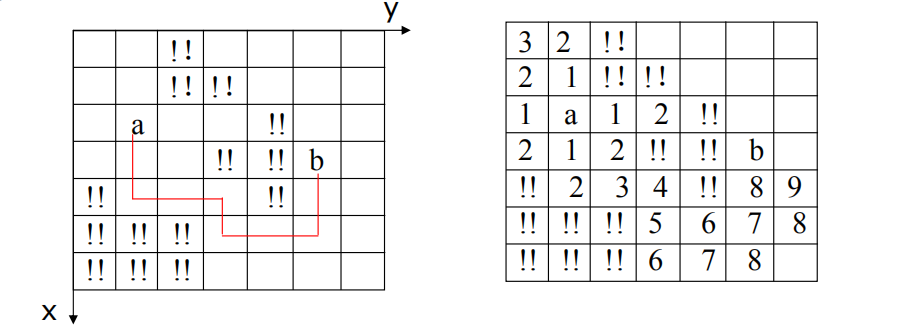
* 方格位置的类Position：
    * 私有成员 row, col；如a=(3,2),b=(4,6)
* 平移offset：
    * 右(0)、下(1)、左(2)、上(3)，
    * 如向右平移一步表示为：offset[0].row=0 and offset[0].col=1。
* 方格状态： grid[i][j]=0可以通过， grid[i][j]=1禁止通过。

In [31]:
def printMatrix(A):
    for a in A:
        for k in a:
            if k!='*':
                print('%3d'%k,end=' ')
            else:
                print('  %s'%k,end=' ')
            
                
        print()

class Position:
    def __init__(self,row,col):
        self.row=row
        self.col=col
    def add(self,p):
        self.row=self.row+p.row
        self.col+=p.col
    def printP(self):
        print("(%d,%d)"%(self.row,self.col))
    def equal(self,p):
        if(self.row==p.row and self.col==p.col):
            return True
        return False
        
def FindPath(start,finish,Pathlen,path):
    if(start.row==finish.row and start.col==finish.col):
        PathLen=0
        return True
    global n,m
    ##1.构建grid
    grid=[[1]*(m+2)]
    for i in range(1,n+1):
        grid.append([0]*(m+2))
    grid.append([1]*(m+2))
    for i in range(1,n+1):
        grid[i][0]=1
        grid[i][m+1]=1
    l=[(1,3),(2,3),(2,4),(3,5),(4,4),(4,5),(5,1),(5,5),(6,1),(6,2),(6,3),(7,1),(7,2),(7,3)]
    for i in l:
        grid[i[0]][i[1]]=1
#     print(grid)
    printMatrix(grid)
    
    #2.定义上下左右移动
    right=Position(0,1)
    down=Position(1,0)
    left=Position(0,-1)
    up=Position(-1,0)
    offset=[right,down,left,up]
    NumOfNbrs=4#相邻方格数
    here=Position(start.row,start.col)
    grid[start.row][start.col]=2
    #3.标记可到达方格位置
    Q=[]
    while(True):
        for i in range(0,NumOfNbrs):
            nbr=Position(here.row,here.col)
            nbr.add(offset[i])
    #         nbr.printP()
            if(grid[nbr.row][nbr.col]==0):
                grid[nbr.row][nbr.col]=grid[here.row][here.col]+1
                if(nbr.equal(finish)):
                    break
                Q.append(nbr)
        if(nbr.equal(finish)):
            break
        if(len(Q)==0):
            return False#无解
        here=Q.pop()
    PathLen=grid[finish.row][finish.col]-2
    path=[0]*PathLen
    ##回溯
    here=finish
    print("标记路径后的grid:")
    printMatrix(grid)
    print("回溯路径：")
    for j in range(PathLen-1,-1,-1):
        path[j]=here
        for i in range(0,NumOfNbrs):
            nbr=Position(here.row,here.col)
            nbr.add(offset[i])
            if(grid[nbr.row][nbr.col]==j+2):
                break
        here=nbr
        nbr.printP()
        grid[nbr.row][nbr.col]='*'
    print("标记路径后的grid:")
    printMatrix(grid)
    
    return True
    
    
    
m=7#m行
n=7#n列
start=Position(3,2)
finish=Position(4,6)
Pathlen=0
path=[]
FindPath(start,finish,Pathlen,path)   

  1   1   1   1   1   1   1   1   1 
  1   0   0   1   0   0   0   0   1 
  1   0   0   1   1   0   0   0   1 
  1   0   0   0   0   1   0   0   1 
  1   0   0   0   1   1   0   0   1 
  1   1   0   0   0   1   0   0   1 
  1   1   1   1   0   0   0   0   1 
  1   1   1   1   0   0   0   0   1 
  1   1   1   1   1   1   1   1   1 
标记路径后的grid:
  1   1   1   1   1   1   1   1   1 
  1   5   4   1   0   0   0   0   1 
  1   4   3   1   1   0   0   0   1 
  1   3   2   3   0   1   0   0   1 
  1   4   3   4   1   1  13   0   1 
  1   1   4   5   6   1  12  13   1 
  1   1   1   1   7   8  11  12   1 
  1   1   1   1   8   9  10  11   1 
  1   1   1   1   1   1   1   1   1 
回溯路径：
(5,6)
(6,6)
(7,6)
(7,5)
(7,4)
(6,4)
(5,4)
(5,3)
(5,2)
(4,2)
(3,2)
标记路径后的grid:
  1   1   1   1   1   1   1   1   1 
  1   5   4   1   0   0   0   0   1 
  1   4   3   1   1   0   0   0   1 
  1   3   *   3   0   1   0   0   1 
  1   4   *   4   1   1  13   0   1 
  1   1   *   *   *   1   *  13   1 
  1   1   1   1 

True

# 4.最小成本搜索--LC搜索
* 优先队列式分枝定界算法**优先级函数**的确定
    * 理想的当前扩展节点X
        1. 以X为根的子树中含有问题的答案节点；
        2. 在所有满足条件1)的活节点中，X距离答案节点“最近”。
    * 节点计算代价的度量
        1. 在生成一个答案节点之前，子树X需要生成的节点数；
        2. 以X为根的子树中，离X最近的那个答案节点到X的**路径长度**。
    * 理想的优先级函数c(.)
        1. 如果X是答案节点，则c(X)是解空间树中由根节点到X的成本(即所用的代价，如深度、计算复杂度等)；
        2. 如果X不是答案节点，而且以X为根的子树中不含答案节点，则c(X)定义为∞；
        3. 如果X不是答案节点，但是以X为根的子树中含答案节点，则c(X)是具有最小成本的答案节点的成本。
    * 优先级估计函数 ĉ(.) = f(X) + g(X)
        * f(X)－－解空间树根节点到X的成本；
        * g(X)－－X到答案节点的计算成本。
    * 最小成本搜索
        * 根据成本估计函数选择下一个扩展节点的策略：
        * 总是选取ĉ(·)值最小的活节点作为下一个扩展节点

# 5.十五谜团问题
* 问题
    * 在一个分成4×4的棋盘上排列15块号牌，
    * 其中会出现一个空格。
    * 移动：棋盘上号牌的一次合法移动是指将与空格相邻的一块号牌移入空格。
    * 目的：15迷问题要求通过一系列合法移动，将号牌的初始排列转换成自然排列。
.
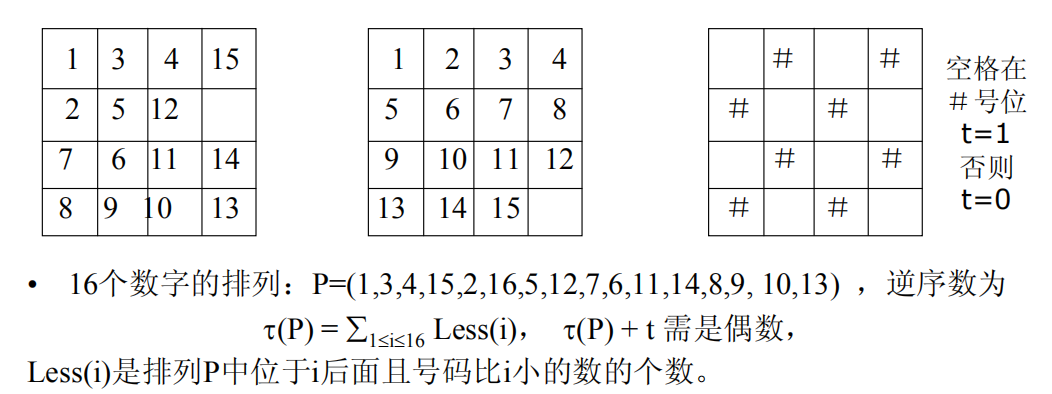
* 优先级函数： ĉ(.) = f(X) + g(X)
    * f(x)是由根到节点X的路径的长度；
    * g(X)=排列X的不在自然位置的号牌数目

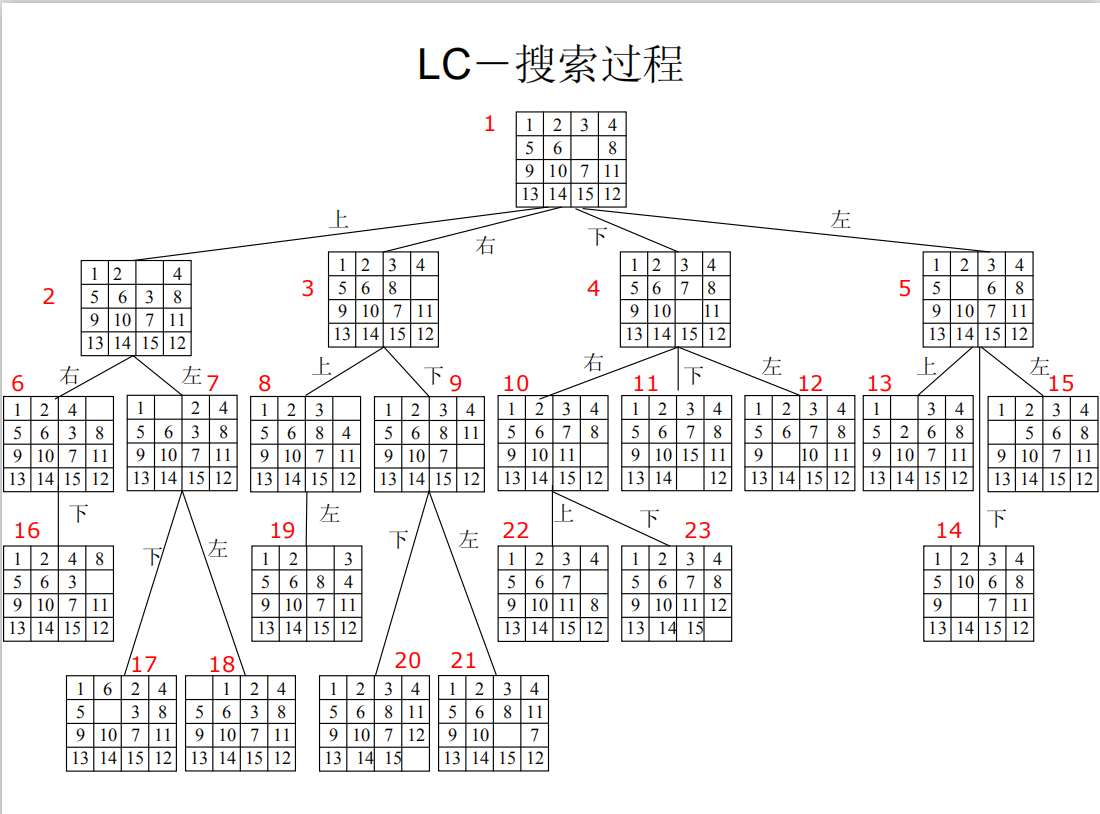

## 5.2成本估计函数应该满足的条件
* 按照成本估价函数ĉ(X)确定的优先级进行搜索，所得到的答案节点
    * 未必是最小成本答案节点。
* 定理7.4.1 在有限的解空间树中，如果对每对节点X和Y都有
    * “c(X) < c(Y)” ＝> “ĉ(X) < ĉ(Y)”
    * 则按照最小成本估计函数搜索能够达到最小成本答案节点。
* 一般情况下，对于成本估计函数有一个基本要求：
    *  ĉ(X)≤ c(X), 对任意节点X；
    * ĉ(X)＝c(X)，当X是答案节点时。

# 6.最小化问题的LC-分枝定界算法

In [ ]:
def LCBB(T,c,ue,cost):

# 7.TSP
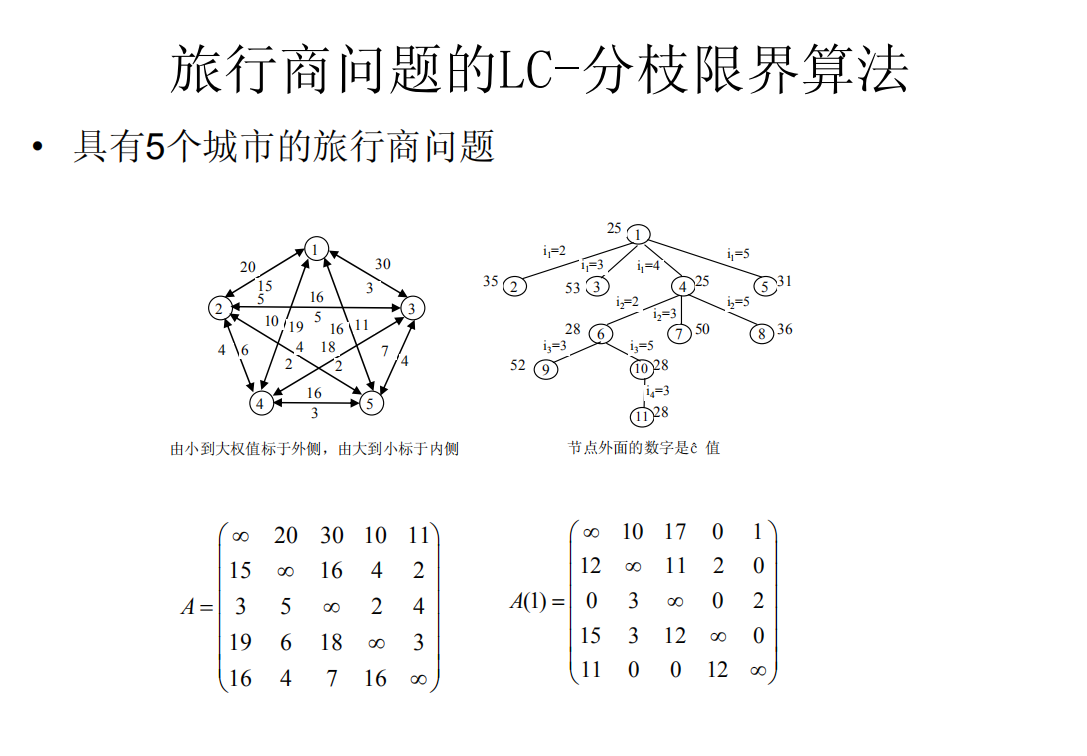

* 约简矩阵A(1):矩阵的某一行、列至少有一个为0
* A-->A(1):先减行ri再减列cj
* 优先级函数
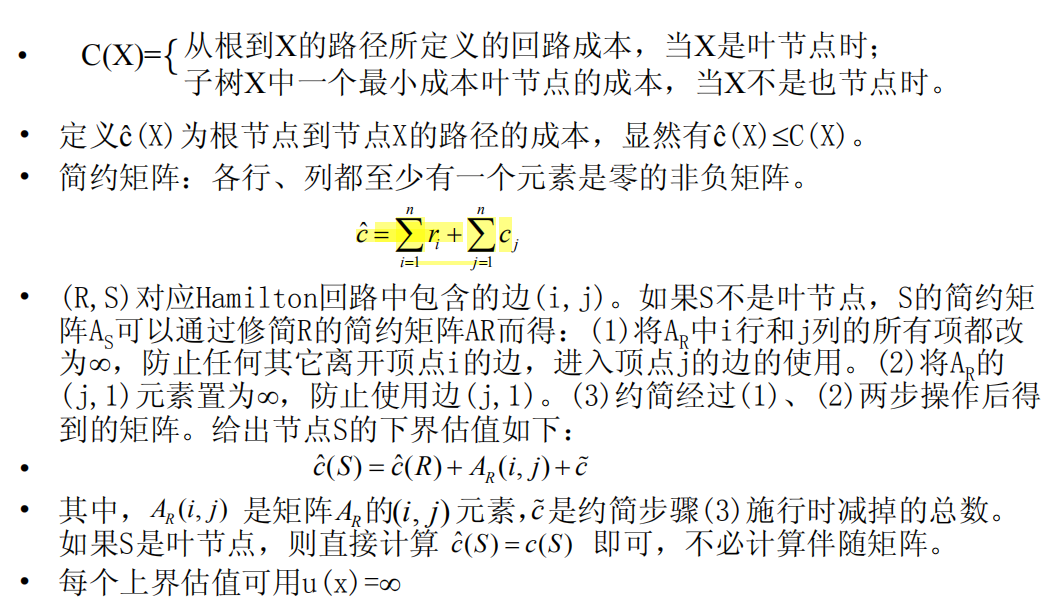
矩阵从1开始

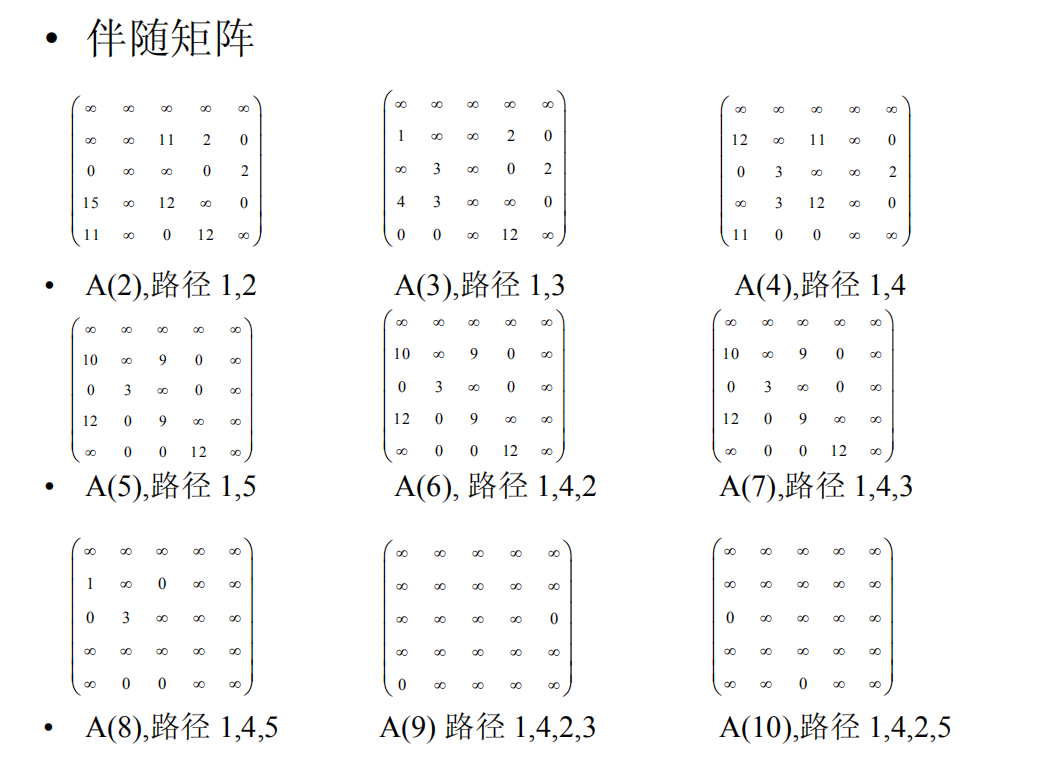
最终结果为：1,4,2,5,3,1，成本为28    

此图中A(6),A(7)错误